###This notebook demonstrates the use of the SwinV2 Vision Transformer for segmentation on a custom dataset.

In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install torchinfo

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import copy
import cv2
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
import torchvision.utils

from zipfile import ZipFile

from transformers import AutoImageProcessor, Swinv2Model

# GPU usage settings

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Google drive mounting

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Use of the pre-trained model setting (load an already trained model or start new training) + other common settings

In [12]:
use_pre_trained = False
save_input_classes = True
save_train_test_splitting = True


In [13]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data/'
CURR_PATH = '/content/gdrive/MyDrive/Colab Notebooks'

FILE_NAME = CURR_PATH + 'model_seg_pytorch_medical.cnn'   # to save the model check-points during the training
FILE_NAME_PR = DATA_PATH + 'model_segEx_swinV2_medical_21_st.cnn' # the pre-trained model

r_size = 256
batch_size = 16
ep_num = 20

zip_name = 'kaggle_3mN.zip'

#Full list of files with MR images (from zip-file)

In [14]:
with ZipFile(DATA_PATH + zip_name, 'r') as f:
    tnames = f.namelist()

len(tnames), tnames[10]

(15944, 'kaggle_3m/TCGA_HT_7475_19970918/')

In [15]:
from zipfile import ZipFile

zip_path = DATA_PATH + zip_name  # Update as per your path

with ZipFile(zip_path, 'r') as f:
    all_names = f.namelist()

    # Filter only .tif files, ignore folder entries
    names = [name for name in all_names if name.endswith('.tif')]

print(len(names), names[10])


15716 kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9.tif


In [16]:
names = [n.split('/')[-1] for n in names]
names = list(filter(lambda x: (x != '' and x != 'data.csv' and x != 'README.md'), names))
names[0], len(names)

('TCGA_CS_6667_20011105_8_mask.tif', 15716)

In [17]:
with ZipFile(DATA_PATH + zip_name, 'r') as f:
    f_images = f.namelist()

f_images = [n for n in f_images if n.endswith('.tif') and (n[:-4] + '_mask.tif') in f_images]

len(f_images), f_images[10]

(7858, 'kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14.tif')

In [18]:
f_masks = list(filter(lambda x: 'mask' in x,  tnames))
if f_masks:  # Check if f_masks is not empty before accessing elements
    print(f_masks[0], len(f_masks))
else:
    print("No masks found in f_names. Please check your file names or filtering logic.")

kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif 7858


#Showing a picture and a mask-picture

In [19]:
def show_input_sample(f_images):
    random.shuffle(f_images)
    with ZipFile(DATA_PATH + zip_name) as archive:
        data = archive.read(f_images[0])
        print(f_images[0][:-4] + '_mask.tif')
        data1 = archive.read(f_images[0][:-4] + '_mask.tif')

    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    print(mask.max(), mask.min(), np.unique(mask))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(mask)
    plt.show()

kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_13_mask.tif
255 0 [  0 255]


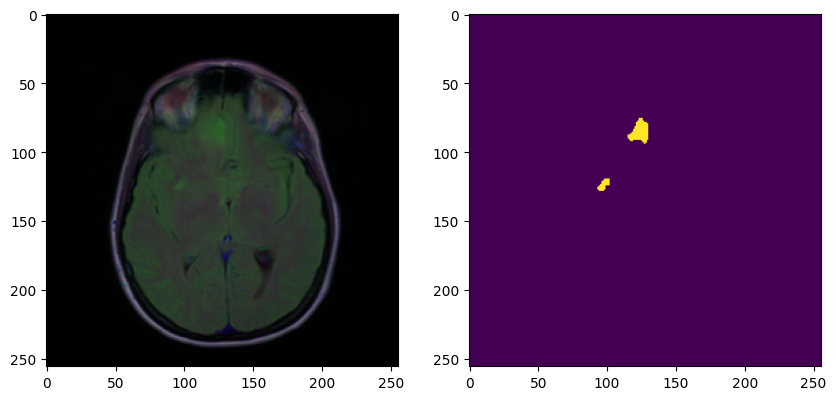

In [21]:
show_input_sample(f_images)

#Swin transformer model loading

In [24]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k")
model_seg = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/915M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/915M [00:00<?, ?B/s]

#Generation batch with pictures-pairs: source image + mask image

In [25]:
class SegmentDataset(Dataset):
    def __init__(self,
                 gen_df,
                 transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((r_size, r_size), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
                 ]),
                 mask_color='GRAY'):
        # Filter gen_df to exclude __MACOSX entries during initialization
        self.gen_df = [item for item in gen_df
                       if "__MACOSX" not in (item if isinstance(item, str) else item[0] and item[1])]
        self.transform = transform
        self.mask_color = mask_color

    def __getitem__(self, index):
        # ... (rest of the __getitem__ method remains the same)
        # Ensure img_name is a properly formatted string
        img_name = self.gen_df[index]
        if isinstance(img_name, tuple):  # Handle tuple case for image-mask pairs
            img_name, mask_name = img_name
        else:  # Handle case where only img_name is provided
            img_name = img_name.strip()  # Strip potential newline characters
            mask_name = img_name[:-4] + '_mask.tif'  # Construct mask name

        # Filter out files from __MACOSX directory
        if "__MACOSX" in img_name or "__MACOSX" in mask_name:
            print(f"Skipping file from __MACOSX directory: {img_name}")
            return self.__getitem__(index + 1 if index + 1 < len(self.gen_df) else 0)  # Recursive call to get the next valid item

        with ZipFile(DATA_PATH + zip_name) as archive:
            # Check if the files exist in the archive
            if img_name not in archive.namelist() or mask_name not in archive.namelist():
                raise FileNotFoundError(f"Image or mask not found in archive: {img_name}, {mask_name}")

            data = archive.read(img_name)
            data1 = archive.read(mask_name)  # Use the constructed mask_name

        # ... (rest of the __getitem__ method remains the same)se the constructed mask_name

        img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR) # Explicitly specify IMREAD_COLOR
        # Check if decoding was successful
        if img is None:
            raise IOError(f"Failed to decode image: {img_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imdecode(np.frombuffer(data1, np.uint8), cv2.IMREAD_GRAYSCALE if self.mask_color == 'GRAY' else cv2.IMREAD_COLOR) # Conditional read mode
        # Check if decoding was successful
        if mask is None:
            raise IOError(f"Failed to decode mask: {mask_name}")

        if self.mask_color == 'GRAY':
            # Ensure mask is single-channel
            if len(mask.shape) > 2:
                mask = mask[:, :, 0]
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert img to PIL Image before applying transforms
        img = Image.fromarray(img)
        img_in = self.transform(img)

        mask = Image.fromarray(mask) # Convert mask to PIL Image before applying transforms
        mask = self.transform(mask)

        img = image_processor(images=img, return_tensors="pt")

        with torch.no_grad():
            x = model_seg.embeddings(**img.to(device))
            input_dimensions=x[1]
            img0 = x[0].squeeze(0)

            x = model_seg.encoder.layers[0](x[0], input_dimensions=input_dimensions)
            img1 = x[0].squeeze(0)

            x = model_seg.encoder.layers[1](x[0], input_dimensions=(input_dimensions[0]//2, input_dimensions[1]//2) )
            img2 = x[0].squeeze(0)

            x = model_seg.encoder.layers[2](x[0], input_dimensions=(input_dimensions[0]//4, input_dimensions[1]//4) )
            img3 = x[0].squeeze(0)

            x = model_seg.encoder.layers[3](x[0], input_dimensions=(input_dimensions[0]//8, input_dimensions[1]//8) )
            x = model_seg.layernorm(x[0])
            img4 = x.squeeze(0)

        return img0, img1, img2, img3, img4, mask, img_in

    def __len__(self):
        return len(self.gen_df)

###Network creation (model, loss function, optimizer)

In [26]:
class Up_Linear(nn.Module):
    def __init__(self, in_ch, size, coef=1):
        super(Up_Linear, self).__init__()
        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        n_ch = int(coef * in_ch)

        self.ln = nn.Sequential(
            nn.Linear(in_ch * 2, n_ch),
            nn.ReLU(inplace=True),
            nn.Linear(n_ch, in_ch * 2),
            nn.ReLU(inplace=True),
        )

        self.size = size

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), 2)
        x = self.ln(x)
        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size, self.size))
        x = self.shuffle(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size*self.size*4))
        x = x.permute(0, 2, 1)
        return x

class MRI_Seg(nn.Module):
    def __init__(self):
        super(MRI_Seg, self).__init__()

        self.ups3 = Up_Linear(1536, 6, 1)
        self.ups2 = Up_Linear(768, 12, 1)
        self.ups1 = Up_Linear(384, 24, 2)
        self.ups0 = Up_Linear(192, 48, 3)

        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        self.out = nn.Sequential(
            nn.Conv2d(24, 1, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x0, x1, x2, x3, x4):
        x = self.ups3(x4, x3)
        x = self.ups2(x, x2)
        x = self.ups1(x, x1)
        x = self.ups0(x, x0)

        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], 96, 96))
        x = self.shuffle(x)
        x = transforms.Resize((r_size, r_size))(x)

        x = self.out(x)
        return x


In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Step 1: Generate verified image-mask pairs
image_mask_pairs = [(img, img[:-4] + '_mask.tif') for img in f_images]

# Step 2: Train-test split (80% train, 20% test)
train_val_pairs, test_pairs = train_test_split(image_mask_pairs, test_size=0.2, random_state=42)

# Step 3: Split training into train/val (e.g., 80% train, 20% val)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.2, random_state=42)

# Step 4: Define transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Step 5: Create datasets
train_dataset = SegmentDataset(gen_df=train_pairs, transform=transform)
val_dataset   = SegmentDataset(gen_df=val_pairs, transform=transform)
test_dataset  = SegmentDataset(gen_df=test_pairs, transform=transform)

# Step 6: Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)
val_dataloader   = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=0)
test_dataloader  = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=0)


In [28]:

net = MRI_Seg().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [29]:
len(train_dataloader)

313

In [30]:
summary(model=net, input_size=[(1, 2304, 192), (1, 576, 384), (1, 144, 768), (1, 36, 1536), (1, 36, 1536)], col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
MRI_Seg                                  [1, 2304, 192]            [1, 1, 256, 256]          --                        True
├─Up_Linear: 1-1                         [1, 36, 1536]             [1, 144, 768]             --                        True
│    └─Sequential: 2-1                   [1, 36, 3072]             [1, 36, 3072]             --                        True
│    │    └─Linear: 3-1                  [1, 36, 3072]             [1, 36, 1536]             4,720,128                 True
│    │    └─ReLU: 3-2                    [1, 36, 1536]             [1, 36, 1536]             --                        --
│    │    └─Linear: 3-3                  [1, 36, 1536]             [1, 36, 3072]             4,721,664                 True
│    │    └─ReLU: 3-4                    [1, 36, 3072]             [1, 36, 3072]             --                        --
│    └─

###Non-trained network output

In [31]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

In [32]:
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

# Make sure net, train_dataloader, and device are already defined
ep_num = 20 # or any number of epochs you want
FILE_NAME = 'MRI_segmentation_model.pth'


In [33]:
net = MRI_Seg().to(device)  # No pretrained weights
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)


In [34]:
import os
import torch
import numpy as np

def dice_score(preds, targets, smooth=1e-5):
    preds = preds.astype(np.bool_)
    targets = targets.astype(np.bool_)
    intersection = np.logical_and(preds, targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def evaluate_dice(net, dataloader):
    net.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for data in dataloader:
            img0, img1, img2, img3, img4, mask, img_in = data

            x0 = img0.to(device)
            x1 = img1.to(device)
            x2 = img2.to(device)
            x3 = img3.to(device)
            x4 = img4.to(device)
            msk = mask.to(device)

            output = net(x0, x1, x2, x3, x4)
            preds = torch.sigmoid(output).cpu().numpy().ravel() > 0.5
            true_masks = msk.cpu().numpy().ravel()

            all_preds.extend(preds)
            all_masks.extend(true_masks)

    return dice_score(np.array(all_preds), np.array(all_masks))

def train_net():
    num_iter = len(train_dataloader)
    ep_init = 0

    model_dir = "/content/drive/MyDrive/MRIsegmentation_models"
    os.makedirs(model_dir, exist_ok=True)

    best_dice = 0.0
    best_model_path = None
    patience = 5
    no_improve_epochs = 0

    for epoch in range(ep_init, ep_num):
        net.train()
        epoch_loss = 0

        print(f"Epoch [{epoch+1}/{ep_num}]")

        for i, data in enumerate(train_dataloader):
            img0, img1, img2, img3, img4, mask, img_in = data

            optimizer.zero_grad()

            x0 = img0.to(device)
            x1 = img1.to(device)
            x2 = img2.to(device)
            x3 = img3.to(device)
            x4 = img4.to(device)
            msk = mask.to(device)

            output = net(x0, x1, x2, x3, x4)
            loss = criterion(output, msk)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / num_iter

        # 🔍 Evaluate on validation set
        val_dice = evaluate_dice(net, val_dataloader)

        print(f"Epoch [{epoch+1}/{ep_num}] Avg Train Loss: {avg_loss:.4f} | Val Dice Score: {val_dice:.4f} | LR: {optimizer.param_groups[0]['lr']}")

        if val_dice > best_dice:
            best_dice = val_dice
            best_model_path = os.path.join(model_dir, f"{FILE_NAME}_best.pt")
            torch.save(net, best_model_path)
            print(f"✅ Best model updated. Saved to: {best_model_path}")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"⚠️ No improvement in Val Dice score for {no_improve_epochs} epoch(s).")

        if no_improve_epochs >= patience:
            print(f"🛑 Early stopping triggered after {patience} epochs without improvement.")
            break

    print(f"🎯 Training complete. Best model saved at Val Dice Score = {best_dice:.4f}")
    print(f"📁 Best model path: {best_model_path}")


In [ ]:
train_net()


Epoch [1/20]
Epoch [1/20] Avg Train Loss: 0.0723 | Val Dice Score: 0.0329 | LR: 0.0001
✅ Best model updated. Saved to: /content/drive/MyDrive/MRIsegmentation_models/MRI_segmentation_model.pth_best.pt
Epoch [2/20]
Epoch [2/20] Avg Train Loss: 0.0135 | Val Dice Score: 0.0366 | LR: 0.0001
✅ Best model updated. Saved to: /content/drive/MyDrive/MRIsegmentation_models/MRI_segmentation_model.pth_best.pt
Epoch [3/20]
Epoch [3/20] Avg Train Loss: 0.0106 | Val Dice Score: 0.0525 | LR: 0.0001
✅ Best model updated. Saved to: /content/drive/MyDrive/MRIsegmentation_models/MRI_segmentation_model.pth_best.pt
Epoch [4/20]
Epoch [4/20] Avg Train Loss: 0.0091 | Val Dice Score: 0.0437 | LR: 0.0001
⚠️ No improvement in Val Dice score for 1 epoch(s).
Epoch [5/20]
Epoch [5/20] Avg Train Loss: 0.0077 | Val Dice Score: 0.0624 | LR: 0.0001
✅ Best model updated. Saved to: /content/drive/MyDrive/MRIsegmentation_models/MRI_segmentation_model.pth_best.pt
Epoch [6/20]
Epoch [6/20] Avg Train Loss: 0.0068 | Val Dice S

In [ ]:
net = torch.load('/content/drive/MyDrive/MRIsegmentation_models/YOUR_MODEL_NAME_best.pt')
net.eval()


###Training pipeline

#Testing

###Showing detection results with mask and rectangle: utility functions

In [128]:
def calc_rect(img_mask):
    ind = np.argwhere(img_mask >= 0.5)
    if len(ind) == 0:
        return None, None
    top_y = min(ind[:,0])
    bottom_y = max(ind[:,0])
    top_x = min(ind[:,1])
    bottom_x = max(ind[:,1])
    return (top_x, top_y), (bottom_x, bottom_y)

def show_results(i0, i1, i2, i3, i4, y, x1, im_id):
    ii0 = Variable(i0).to(device)
    ii1 = Variable(i1).to(device)
    ii2 = Variable(i2).to(device)
    ii3 = Variable(i3).to(device)
    ii4 = Variable(i4).to(device)
    with torch.no_grad():
        pred = net(ii0, ii1, ii2, ii3, ii4)
    pr = pred[im_id].cpu().detach().numpy()[0]

    xim = copy.deepcopy(x1[im_id].permute(1, 2, 0).cpu().detach().numpy())
    # just to transform numpy array to cv2 image:
    xim = cv2.resize(xim, (r_size, r_size))
    top_left, bottom_right = calc_rect(pr)
    if top_left is not None:
        cv2.rectangle(xim, top_left, bottom_right, (255, 0, 0), 2)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(y[im_id].cpu().detach().numpy()[0])
    axes[1].imshow(pr > 0.5)
    axes[2].imshow(xim)

    plt.show()

In [129]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

###Reference mask, predicted mask, detected rectangle area

###Accuracy (IoU) calculation:

###Data loaders for IoU calculation data (both training and test sets):

In [133]:
test_dataloader1 = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)


test_dataloader2 = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

In [134]:
dataiter = iter(test_dataloader1)

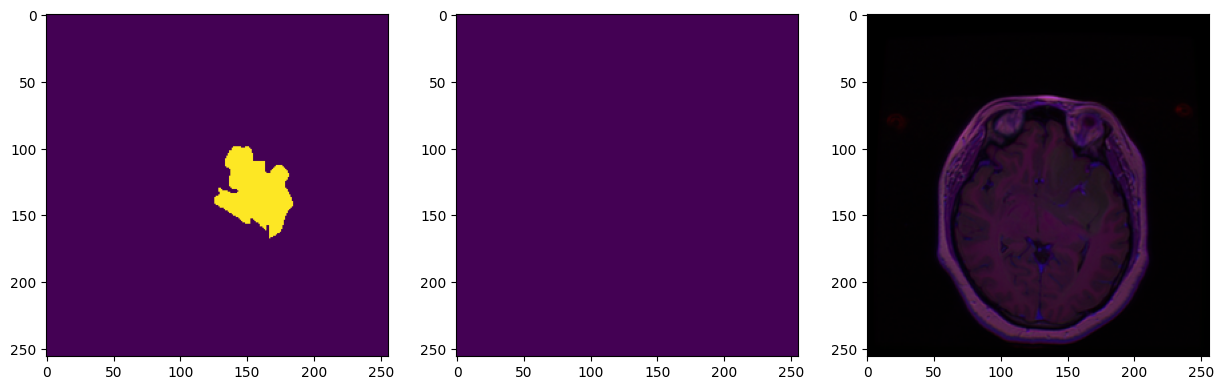

In [135]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter)
show_results(i0, i1, i2, i3, i4, y, x1, 0)

In [ ]:
dataiter2 = iter(test_dataloader2)

In [ ]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter2)
show_results(i0, i1, i2, i3, i4, y, x1, 0)

###Quality metrics calculation function

In [136]:
def calc_accuracy(test_dataloader, set_id, model, sample_num=None):
    batch_size = 1
    if not sample_num:
        N = len(test_dataloader)
    else:
        if sample_num <= 0:
            sample_num = len(test_dataloader)
        N = min(sample_num, len(test_dataloader))

    And = 0
    Uni = 0
    Uni_dice = 0
    IoU_Pic_mean = 0
    calc_mask = 0

    T0 = 0
    T1 = 0
    F0 = 0
    F1 = 0

    for i, data in enumerate(test_dataloader, 0):
        img0, img1, img2, img3, img4, yy, xs = data

        x0 = Variable(img0).to(device)
        x1 = Variable(img1).to(device)
        x2 = Variable(img2).to(device)
        x3 = Variable(img3).to(device)
        x4 = Variable(img4).to(device)

        with torch.no_grad():
            xx1 = model(x0, x1, x2, x3, x4)
        xx1 = xx1[0][0].cpu().detach().numpy()
        yy = yy[0][0].cpu().detach().numpy()
        xx1[xx1 >= 0.5] = 1
        xx1[xx1 < 0.5] = 0

        owl = np.sum(xx1 * yy)
        And += owl
        a_uni_dice = np.sum(xx1 + yy)
        a_uni = a_uni_dice - owl
        Uni += a_uni
        Uni_dice += a_uni_dice

        if a_uni > 0:
            calc_mask += 1
            IoU_Pic = owl / a_uni
            IoU_Pic_mean += IoU_Pic
            if yy.max() == 0:
                F1 += 1
            else:
                if xx1.max() == 0:
                    F0 += 1
                else:
                    T1 += 1
        else:
            T0 += 1

        # Removed: print('{}:  i = {}, And = {}, Uni = {}'.format(set_id, i, And, Uni))

        if i >= N - 1:
            break

    IoU_av = And / Uni
    Dice = 2 * And / Uni_dice
    if calc_mask > 0:
        IoU_Pic_mean = IoU_Pic_mean / calc_mask

    recall = T1 / (T1 + F0 + 1e-8)
    precision = T1 / (T1 + F1 + 1e-8)
    F_measure = (2 * recall * precision) / (recall + precision + 1e-8)

    print(f"\n--- {set_id.upper()} METRICS ---")
    print(f"IoU Average     : {IoU_av:.4f}")
    print(f"IoU Pic Mean    : {IoU_Pic_mean:.4f}")
    print(f"F-measure       : {F_measure:.4f}")
    print(f"Dice Coefficient: {Dice:.4f}")
    print(f"T0 = {T0}, T1 = {T1}, F0 = {F0}, F1 = {F1}\n")

    return IoU_av, IoU_Pic_mean, F_measure, Dice


###Quality metrics calculation on the training set

In [137]:
IoU_tr, IoU_Pic_mean_tr, F_measure_tr, Dice_tr = calc_accuracy(test_dataloader1, 'train', net, sample_num=550)

train:  i = 0, And = 3376.0, Uni = 5131.0
train:  i = 1, And = 3376.0, Uni = 5131.0
train:  i = 2, And = 3376.0, Uni = 5131.0
train:  i = 3, And = 3376.0, Uni = 5131.0
train:  i = 4, And = 7535.0, Uni = 9794.0
train:  i = 5, And = 7535.0, Uni = 9794.0
train:  i = 6, And = 7535.0, Uni = 9794.0
train:  i = 7, And = 7535.0, Uni = 9794.0
train:  i = 8, And = 7535.0, Uni = 9794.0
train:  i = 9, And = 8496.0, Uni = 11858.0
train:  i = 10, And = 8496.0, Uni = 11858.0
train:  i = 11, And = 8496.0, Uni = 11858.0
train:  i = 12, And = 8496.0, Uni = 12776.0
train:  i = 13, And = 8496.0, Uni = 12776.0
train:  i = 14, And = 8496.0, Uni = 12776.0
train:  i = 15, And = 9302.0, Uni = 14106.0
train:  i = 16, And = 10716.0, Uni = 16076.0
train:  i = 17, And = 13651.0, Uni = 20083.0
train:  i = 18, And = 13651.0, Uni = 20083.0
train:  i = 19, And = 13651.0, Uni = 20355.0
train:  i = 20, And = 13651.0, Uni = 20355.0
train:  i = 21, And = 13651.0, Uni = 20355.0
train:  i = 22, And = 13651.0, Uni = 20355.0


In [138]:
print('training set: IoU = {}, IoU_pic_mean = {}, F_measure = {}, Dice = {}'.format(IoU_tr, IoU_Pic_mean_tr, F_measure_tr, Dice_tr))

training set: IoU = 0.5960625410079956, IoU_pic_mean = 0.4270015060901642, F_measure = 0.8296296296296295, Dice = 0.7469162344932556


###Quality metrics calculation on the test set

In [139]:
IoU_ts, IoU_Pic_mean_ts, F_measure_ts, Dice_ts = calc_accuracy(test_dataloader2, 'test', net)

test:  i = 0, And = 0.0, Uni = 238.0
test:  i = 1, And = 0.0, Uni = 238.0
test:  i = 2, And = 0.0, Uni = 238.0
test:  i = 3, And = 0.0, Uni = 238.0
test:  i = 4, And = 2510.0, Uni = 3164.0
test:  i = 5, And = 2510.0, Uni = 3164.0
test:  i = 6, And = 2510.0, Uni = 3241.0
test:  i = 7, And = 2780.0, Uni = 4236.0
test:  i = 8, And = 4048.0, Uni = 7685.0
test:  i = 9, And = 4048.0, Uni = 9387.0
test:  i = 10, And = 4048.0, Uni = 10981.0
test:  i = 11, And = 4048.0, Uni = 10982.0
test:  i = 12, And = 4048.0, Uni = 10982.0
test:  i = 13, And = 4048.0, Uni = 10982.0
test:  i = 14, And = 5364.0, Uni = 13294.0
test:  i = 15, And = 5364.0, Uni = 13294.0
test:  i = 16, And = 5364.0, Uni = 13374.0
test:  i = 17, And = 5919.0, Uni = 15023.0
test:  i = 18, And = 5919.0, Uni = 15324.0
test:  i = 19, And = 5919.0, Uni = 15324.0
test:  i = 20, And = 5919.0, Uni = 15366.0
test:  i = 21, And = 5919.0, Uni = 15366.0
test:  i = 22, And = 5919.0, Uni = 15366.0
test:  i = 23, And = 6137.0, Uni = 16219.0
test

In [140]:
print('test set: IoU = {}, IoU_pic_mean = {}, F_measure = {}, Dice = {}'.format(IoU_ts, IoU_Pic_mean_ts, F_measure_ts, Dice_ts))

test set: IoU = 0.5451775789260864, IoU_pic_mean = 0.37008774280548096, F_measure = 0.8022813688212928, Dice = 0.7056503891944885
